In [29]:
from utils import load_data
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Loading Data with Helper Functions

In [2]:
mice = load_data()

In [3]:
mouse2 = mice[2]

In [4]:
mice.keys()

dict_keys([2, 3, 4, 5, 6, 7, 8, 9, 10])

In [5]:
# percent reads / times
mouse2_pct = mouse2['reads_percent']
mouse2_abs = mouse2['reads_abs_mean']
mouse2_t = mouse2['times']
mouse2_otu = mouse2['otus']
mouse2_stand = mouse2['reads_standardized']

## Visualizing different time series

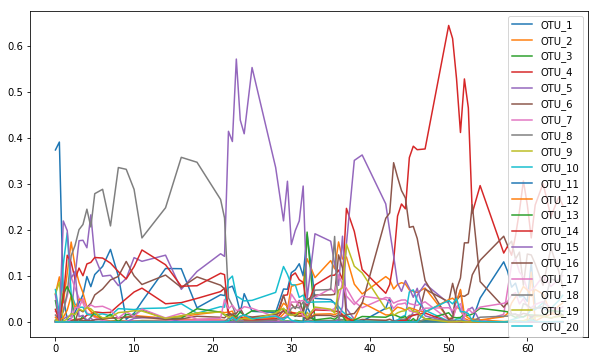

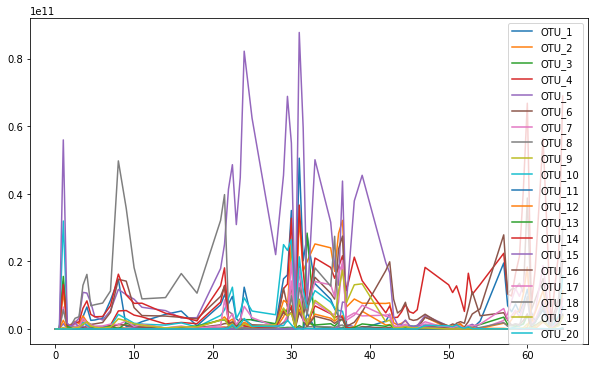

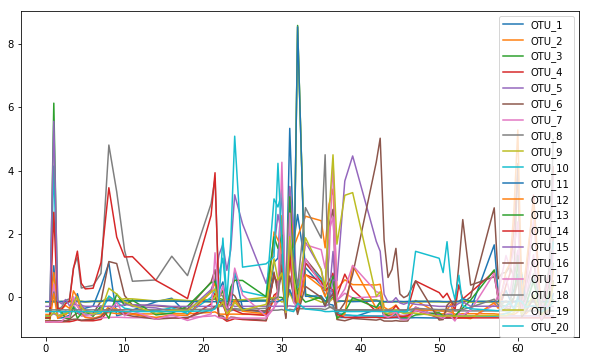

In [6]:
# most important reads: 1, 2, 6, 10

IMP_READS = np.arange(20)

import matplotlib.pyplot as plt
import numpy as np

# visualize
plt.figure(figsize=(10,6))
for i in IMP_READS:
    plt.plot(mouse2_t, mouse2_pct[i, :], label=str(mouse2_otu[i]))
plt.legend();

# visualize
plt.figure(figsize=(10,6))
for i in IMP_READS:
    plt.plot(mouse2_t, mouse2_abs[i, :], label=str(mouse2_otu[i]))
plt.legend();

# visualize
plt.figure(figsize=(10,6))
for i in IMP_READS:
    plt.plot(mouse2_t, mouse2_stand[i, :], label=str(mouse2_otu[i]))
plt.legend();

Above we visualized the different time series. We chose to use the standardized set (third plot) where we have made each time series centered at zero with standard deviation 1.

When we think about the experiments at a high level, we realize that the mouse within the healthy group, and those separately in the IBD group, satisfy the property of *exchangeability* whereby we can permute their numbers and our beliefs about them should not change. In a typical Bayesian model, we may impose this through a hierarchical parameter-sharing construct. However, we instead simply take the mean of the time series within the healthy and IBD groups. This way we are reducing the within-group variance and pooling information.

In [54]:
import torch
from clstm import cLSTM, train_model_gista, train_model_adam

# For GPU acceleration
device = torch.device('cuda')

# Taking averages of Healthy and IBD Groups
top_reads=np.zeros_like(mice[2]['reads_standardized'][IMP_READS, :])

for mid in [2,3,4,5]: # healthy
    top_reads += mice[mid]['reads_standardized'][IMP_READS, :]
    
mean_reads_healthy = top_reads / 4
mean_reads_healthy = mean_reads_healthy.T

top_reads=np.zeros_like(mice[6]['reads_standardized'][IMP_READS, :])

for mid in [6,7,8,9,10]: # IBD
    top_reads += mice[mid]['reads_standardized'][IMP_READS, :]

mean_reads_IBD = top_reads / 5
mean_reads_IBD = mean_reads_IBD.T

X_torch_healthy = torch.tensor(mean_reads_healthy[np.newaxis], dtype=torch.float32, device=device)
X_torch_IBD = torch.tensor(mean_reads_IBD[np.newaxis], dtype=torch.float32, device=device)

These parameters were derived from our Bayesian Optimization procedure, so we use them.

In [55]:
best_params={ 'lam_ridge': 0.00000316,
              'lam': 0.151,
              'lr': 0.00398,
              'n_hidden': 208,
              'truncation': 9,
              'max_iter': 2500
            }

In [59]:
from copy import deepcopy

p = len(IMP_READS)

healthy_pretrain = cLSTM(p, best_params['n_hidden']).cuda(device=device)
train_loss_healthy = train_model_adam(healthy_pretrain, X_torch_healthy, best_params['lr'], 500, 100, truncation=best_params['truncation'], verbose=2)

IBD_pretrain = cLSTM(p, best_params['n_hidden']).cuda(device=device)
train_loss_IBD = train_model_adam(IBD_pretrain, X_torch_IBD, best_params['lr'], 500, 100, truncation=best_params['truncation'], verbose=2)

----------Iter = 100----------
Loss = 0.027543
----------Iter = 200----------
Loss = 0.010021
----------Iter = 300----------
Loss = 0.002614
----------Iter = 400----------
Loss = 0.000587
----------Iter = 500----------
Loss = 0.000202
----------Iter = 100----------
Loss = 0.015830
----------Iter = 200----------
Loss = 0.004064
----------Iter = 300----------
Loss = 0.000898
----------Iter = 400----------
Loss = 0.000473
----------Iter = 500----------
Loss = 0.000121


In [60]:
# check preds
preds_healthy, hidden = healthy_pretrain(X_torch_healthy)
preds_IBD, hidden = IBD_pretrain(X_torch_IBD)

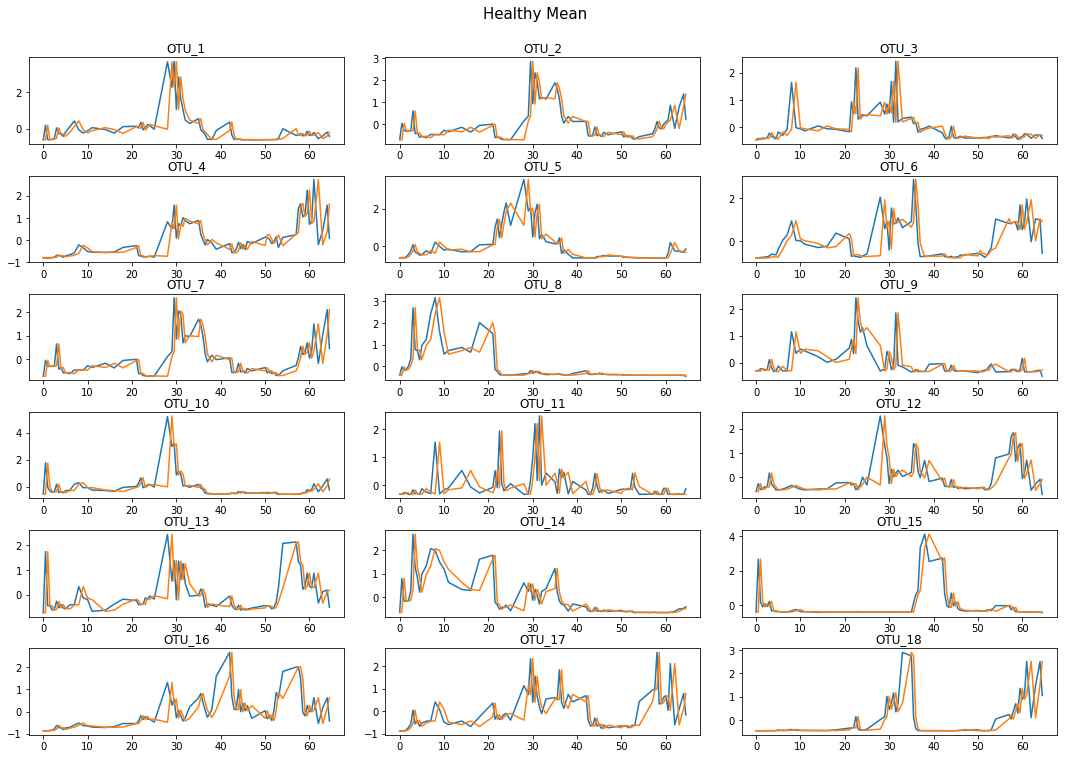

In [63]:
fig, ax = plt.subplots(p//3, 3, figsize=(15,10))
fig.tight_layout()
fig.suptitle('Healthy Mean', y=1.05, fontsize=15)
ax = ax.ravel()
for i in range(p):
    if i > len(ax) - 1:
        break

    ax[i].plot(mouse2_t, preds_healthy[0,:,i].cpu().detach().numpy(), label='preds')
    ax[i].plot(mouse2_t, mean_reads_healthy[:,i], label='true')
    ax[i].set_title('{}'.format(mouse2_otu[i]))

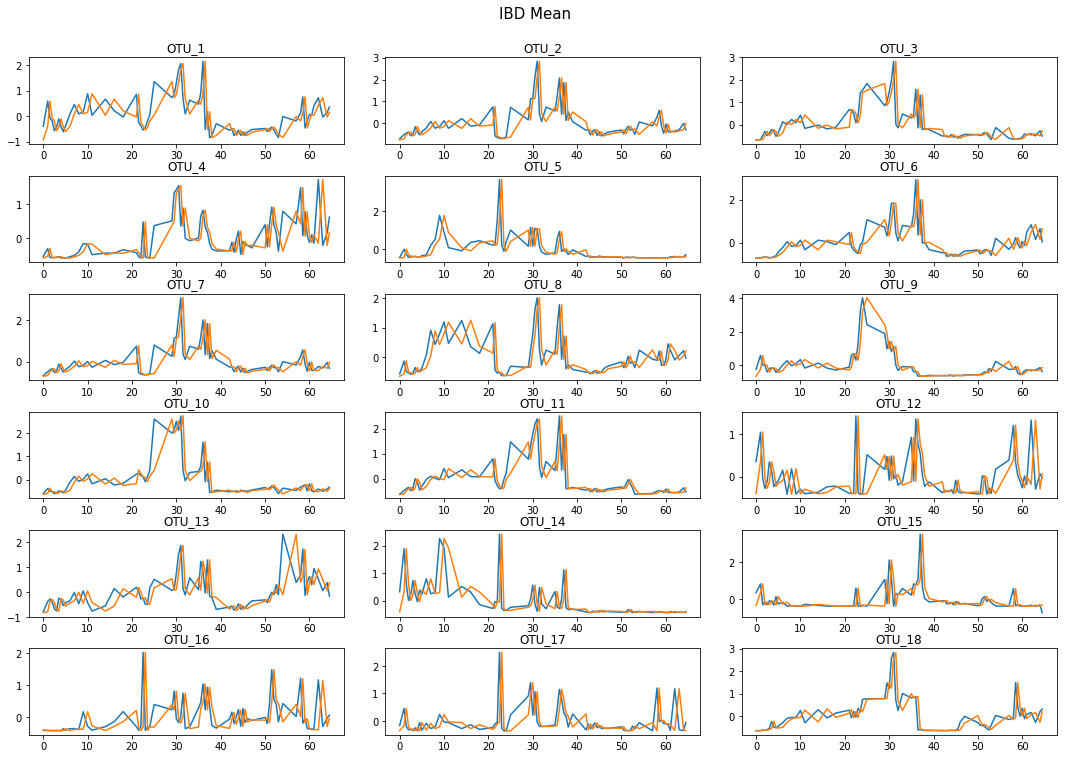

In [64]:
fig, ax = plt.subplots(p//3, 3, figsize=(15,10))
fig.tight_layout()
fig.suptitle('IBD Mean', y=1.05, fontsize=15)
ax = ax.ravel()

mouse6_t = mice[6]['times']
mouse6_otu = mice[6]['otus']

for i in range(p):
    if i > len(ax) - 1:
        break

    ax[i].plot(mouse6_t, preds_IBD[0,:,i].cpu().detach().numpy(), label='preds')
    ax[i].plot(mouse6_t, mean_reads_IBD[:,i], label='true')
    ax[i].set_title('{}'.format(mouse6_otu[i]))

Clearly our models are overfitting, but we only use this to visualize the difference when we impose the Granger Causality regularization penalty.

## Training on Mean Healthy, Mean IBD with GISTA

training on healthy
----------Iter = 500----------
Total loss = 2.904733
MSE = 0.295704, Ridge = 0.000002, Nonsmooth = 2.609027
Variable usage = 100.00%
----------Iter = 1000----------
Total loss = 1.994849
MSE = 0.262705, Ridge = 0.000004, Nonsmooth = 1.732140
Variable usage = 100.00%
----------Iter = 1500----------
Total loss = 1.132515
MSE = 0.258582, Ridge = 0.000005, Nonsmooth = 0.873929
Variable usage = 100.00%
----------Iter = 2000----------
Total loss = 0.438596
MSE = 0.284579, Ridge = 0.000006, Nonsmooth = 0.154011
Variable usage = 52.75%
----------Iter = 2500----------
Total loss = 0.390695
MSE = 0.290327, Ridge = 0.000008, Nonsmooth = 0.100361
Variable usage = 24.75%
training on IBD
----------Iter = 500----------
Total loss = 2.850675
MSE = 0.256196, Ridge = 0.000002, Nonsmooth = 2.594477
Variable usage = 100.00%
----------Iter = 1000----------
Total loss = 1.943397
MSE = 0.233078, Ridge = 0.000003, Nonsmooth = 1.710316
Variable usage = 100.00%
----------Iter = 1500---------

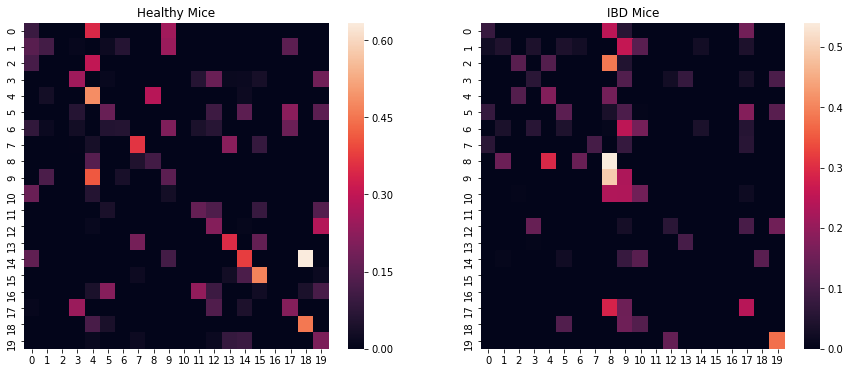

In [35]:
pretrained_models=[]
gc_models=[]
gc_matrices=[]

pretrain_eps=20
gc_eps=2500
check_every=500

top_reads=np.zeros_like(mice[2]['reads_standardized'][IMP_READS, :])

for mid in [2,3,4,5]: # healthy
    top_reads += mice[mid]['reads_standardized'][IMP_READS, :]
    
mean_reads_healthy = top_reads / 4
mean_reads_healthy = mean_reads_healthy.T

top_reads=np.zeros_like(mice[6]['reads_standardized'][IMP_READS, :])

for mid in [6,7,8,9,10]: # IBD
    top_reads += mice[mid]['reads_standardized'][IMP_READS, :]

mean_reads_IBD = top_reads / 5
mean_reads_IBD = mean_reads_IBD.T

X_torch_healthy = torch.tensor(mean_reads_healthy[np.newaxis], dtype=torch.float32, device=device)
X_torch_IBD = torch.tensor(mean_reads_IBD[np.newaxis], dtype=torch.float32, device=device)

# gc train on healthy
print('training on healthy')
healthy_model = cLSTM(p, best_params['n_hidden']).cuda(device=device)
train_loss_list, train_mse_list = train_model_gista(
  healthy_model, X_torch_healthy, lam=best_params['lam'], lam_ridge=best_params['lam_ridge'], 
  lr=best_params['lr'], truncation=best_params['truncation'], max_iter=gc_eps, check_every=check_every,
)

# fig, ax = plt.subplots(1,2, figsize=(15,6))
# ax[0].set_title('Healthy Mice')
# sns.heatmap(healthy_model.GC(threshold=False).cpu().detach().numpy(), ax=ax[0])

# gc train on IBDs
print('training on IBD')
IBD_model = cLSTM(p, best_params['n_hidden']).cuda(device=device)
train_loss_list, train_mse_list = train_model_gista(
  IBD_model, X_torch_IBD, lam=best_params['lam'], lam_ridge=best_params['lam_ridge'], 
  lr=best_params['lr'], truncation=best_params['truncation'], max_iter=gc_eps, check_every=check_every,
)
# ax[1].set_title('IBD Mice')
# sns.heatmap(IBD_model.GC(threshold=False).cpu().cpu().detach().numpy(), ax=ax[1]);

Above and below we see thhe same graph with just a different colormap. We are looking at the Granger causality weights for the top 20 bacteria.

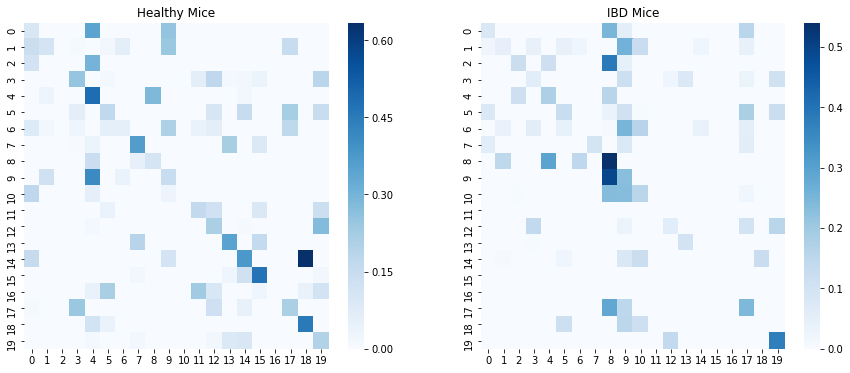

In [36]:
fig, ax = plt.subplots(1,2, figsize=(15,6))
ax[0].set_title('Healthy Mice')
sns.heatmap(healthy_model.GC(threshold=False).cpu().detach().numpy(), ax=ax[0], cmap='Blues')
ax[1].set_title('IBD Mice')
sns.heatmap(IBD_model.GC(threshold=False).cpu().cpu().detach().numpy(), ax=ax[1], cmap='Blues');

In [40]:
GC_healthy = [torch.sum(net.lstm.weight_ih_l0, dim=0)
              for net in healthy_model.networks]
GC_healthy = torch.stack(GC_healthy)

GC_IBD = [torch.sum(net.lstm.weight_ih_l0, dim=0)
              for net in IBD_model.networks]
GC_IBD = torch.stack(GC_IBD)

Here, instead of taking the L2 norm of the weights, we take the sum instead to allow  negative values.

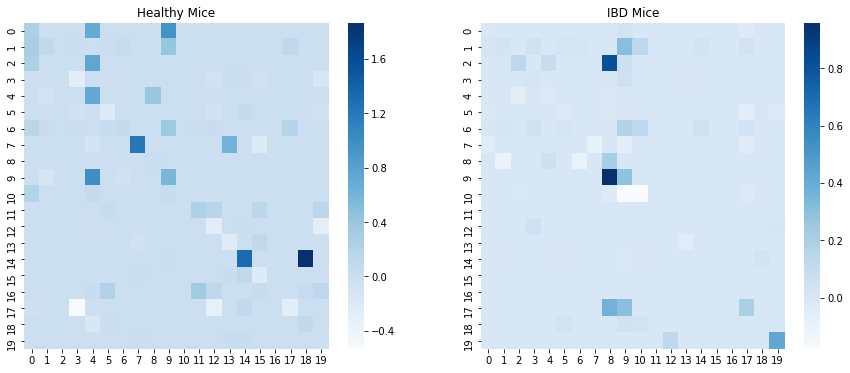

In [41]:
fig, ax = plt.subplots(1,2, figsize=(15,6))
ax[0].set_title('Healthy Mice')
sns.heatmap(GC_healthy.cpu().detach().numpy(), ax=ax[0], cmap='Blues')
ax[1].set_title('IBD Mice')
sns.heatmap(GC_IBD.cpu().detach().numpy(), ax=ax[1], cmap='Blues');

Now let's compare the preds from pre-training with these GISTA model preds.

In [65]:
# check preds
preds_healthy_gista, hidden = healthy_model(X_torch_healthy)
preds_IBD_gista, hidden = IBD_model(X_torch_IBD)

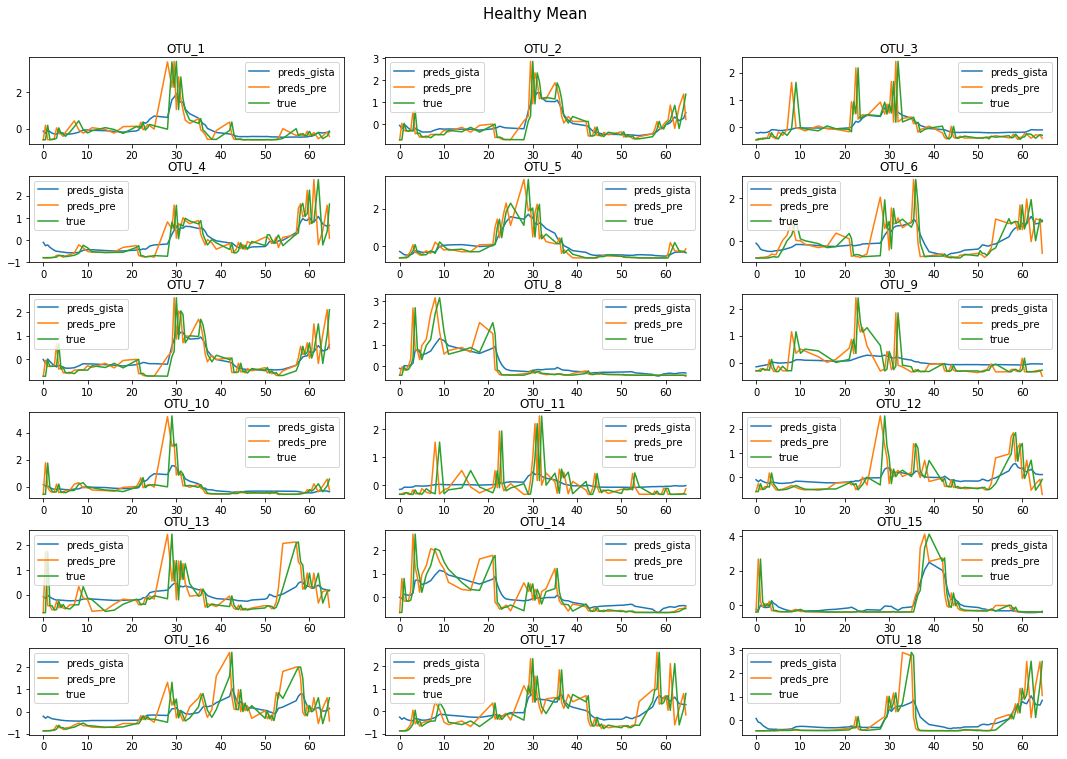

In [67]:
fig, ax = plt.subplots(p//3, 3, figsize=(15,10))
fig.tight_layout()
fig.suptitle('Healthy Mean', y=1.05, fontsize=15)
ax = ax.ravel()
for i in range(p):
    if i > len(ax) - 1:
        breaks

    ax[i].plot(mouse2_t, preds_healthy_gista[0,:,i].cpu().detach().numpy(), label='preds_gista')
    ax[i].plot(mouse2_t, preds_healthy[0,:,i].cpu().detach().numpy(), label='preds_pre')
    ax[i].plot(mouse2_t, mean_reads_healthy[:,i], label='true')
    ax[i].legend()
    ax[i].set_title('{}'.format(mouse2_otu[i]))

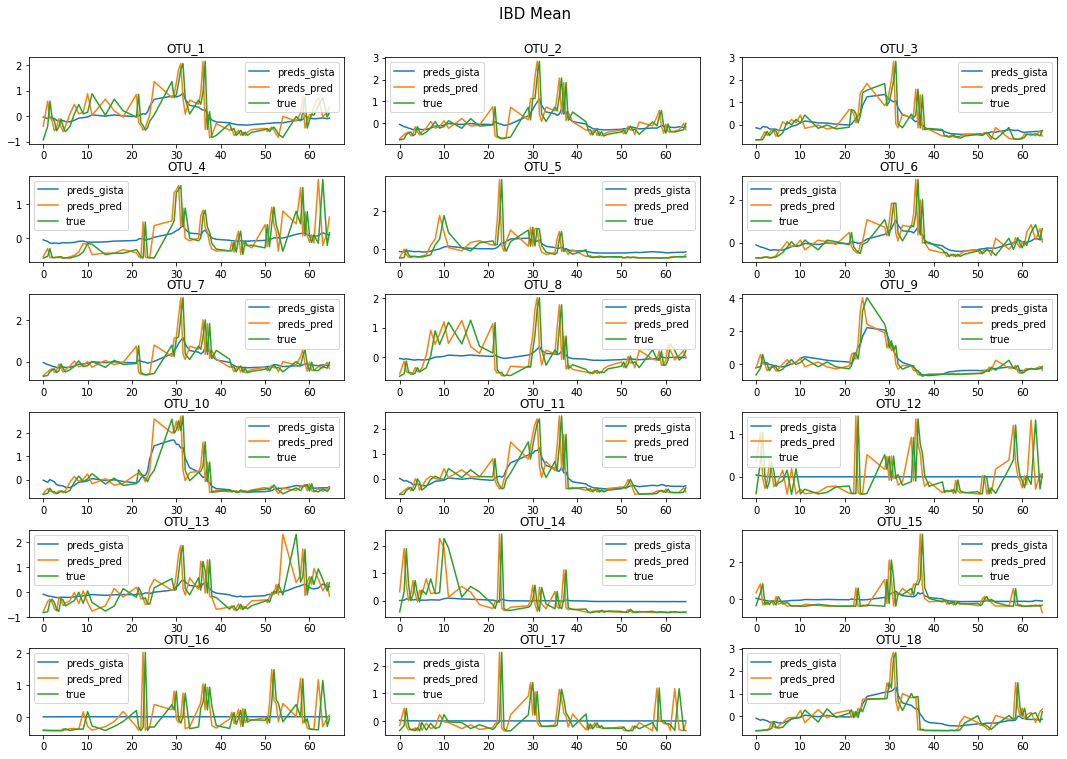

In [69]:
fig, ax = plt.subplots(p//3, 3, figsize=(15,10))
fig.tight_layout()
fig.suptitle('IBD Mean', y=1.05, fontsize=15)
ax = ax.ravel()

mouse6_t = mice[6]['times']
mouse6_otu = mice[6]['otus']

for i in range(p):
    if i > len(ax) - 1:
        break

    ax[i].plot(mouse6_t, preds_IBD_gista[0,:,i].cpu().detach().numpy(), label='preds_gista')
    ax[i].plot(mouse6_t, preds_IBD[0,:,i].cpu().detach().numpy(), label='preds_pred')
    ax[i].plot(mouse6_t, mean_reads_IBD[:,i], label='true')
    ax[i].legend()
    ax[i].set_title('{}'.format(mouse6_otu[i]))

We see what we expect: the blue line, which represents the predictions from the GISTA-trained models, are smoothed out due to the penalty imposed on the input layer of the network (the layer which allows information to flow between time series). 